In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene as pv

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [2]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import torch
import random
from collections import namedtuple
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_size = "160m"
model = f"EleutherAI/pythia-{model_size}"  # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [4]:
needs_and_rooms = [
    ("hungry", "kitchen"),
    ("tired", "bedroom"),
    ("bored", "garden"),
]

In [5]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label"])

names = [
    "Donald",
    "Gary",
    "Deborah",
    "Nancy",
    "Diane",
    "Peter",
    "Kevin",
    "Daniel",
    "Roger",
    "Ralph",
    "Linda",
    "Keith",
    "Paul",
    "Willie",
    "Denise",
    "Marie",
    "Terry",
    "Kayla",
    "Elizabeth",
    "Kelly",
    "Gabriel",
    "Cynthia",
    "Joseph",
    "Harold",
    "Frances",
    "Andrew",
    "Alexis",
    "Bradley",
    "James",
    "Thomas",
    "Jason",
    "Michael",
    "Gregory",
    "Sean",
    "Vincent",
    "Justin",
    "Janet",
    "Sarah",
    "Andrea",
    "Amy",
    "Joan",
    "Kimberly",
    "Natalie",
    "Gerald",
    "Edward",
    "Lisa",
    "Marilyn",
    "Ronald",
    "Victoria",
    "Eugene",
    "Christina",
    "Samantha",
    "Matthew",
    "Douglas",
    "Kenneth",
    "Sophia",
    "Barbara",
    "Margaret",
    "Hannah",
    "Ryan",
    "Megan",
    "Sandra",
    "Robert",
    "Madison",
    "Carolyn",
    "Amanda",
    "Scott",
    "Anthony",
    "Mary",
    "Eric",
    "William",
    "Lawrence",
    "Christian",
    "Lori",
    "Henry",
    "Betty",
    "Dorothy",
    "Samuel",
    "Stephanie",
    "Teresa",
    "Nicole",
    "Julia",
    "Rebecca",
    "Mason",
    "Julie",
    "Emma",
    "Jeremy",
    "Olivia",
    "Larry",
    "Juan",
    "Adam",
    "Alice",
    "Amber",
    "Joe",
    "Angela",
    "Sara",
    "Judy",
    "Christopher",
    "Raymond",
    "Jordan",
    "Karen",
    "Stephen",
    "Kathleen",
    "Billy",
    "Rachel",
    "Diana",
    "Emily",
    "Debra",
    "Roy",
    "Susan",
    "Bobby",
    "Gloria",
    "Doris",
    "Patricia",
    "Ethan",
    "Bruce",
    "David",
    "Richard",
    "Judith",
    "Michelle",
    "Timothy",
    "Frank",
    "Philip",
    "Melissa",
    "Cheryl",
    "Isabella",
    "Jack",
    "Randy",
    "Danielle",
    "Jennifer",
    "Kyle",
    "Walter",
    "Austin",
    "Janice",
    "Sharon",
    "Jean",
    "Steven",
    "Russell",
    "Christine",
    "Theresa",
    "Katherine",
    "Maria",
    "Jesse",
    "Ann",
    "Arthur",
    "Brandon",
    "Jose",
    "Carol",
    "Jacqueline",
    "Joyce",
    "George",
    "Alexander",
    "Patrick",
    "Zachary",
    "Carl",
    "Beverly",
    "Evelyn",
    "Virginia",
    "Charlotte",
    "Jonathan",
    "Laura",
    "John",
    "Charles",
    "Brian",
    "Nicholas",
    "Dylan",
    "Tyler",
    "Jeffrey",
    "Jessica",
    "Helen",
    "Logan",
    "Martha",
    "Albert",
    "Jerry",
    "Nathan",
    "Brenda",
    "Ruth",
    "Donna",
    "Brittany",
    "Shirley",
    "Pamela",
    "Catherine",
    "Lauren",
    "Abigail",
    "Kathryn",
    "Noah",
    "Aaron",
    "Bryan",
    "Grace",
    "Elijah",
    "Heather",
    "Alan",
    "Mark",
    "Wayne",
    "Jacob",
    "Ashley",
    "Benjamin",
    "Joshua",
    "Dennis",
    "Anna",
]

names = [name for name in names if len(tokenizer.tokenize(name)) == 1]


def make_pair(tokenizer, base_name, src_name, base_label, src_label):
    base = tokenizer(
        f"<|endoftext|>{base_name} is {base_label[0]}. {base_name} will go to the",
        return_tensors="pt",
    )
    src = tokenizer(
        f"<|endoftext|>{src_name} is {src_label[0]}. {src_name} will go to the",
        return_tensors="pt",
    )
    base_label = tokenizer.encode(" " + base_label[1])[0]
    src_label = tokenizer.encode(" " + src_label[1])[0]
    return Example(base, src, base_label, src_label)


def sample_example(tokenizer):
    # sample labels (not matching)
    base_label = random.choice(needs_and_rooms)
    src_label = random.choice(
        [tupl for tupl in needs_and_rooms if tupl[0] != base_label[0]]
    )

    # sample names
    base_name = random.choice(names)
    src_name = random.choice([name for name in names if name != base_name])

    return make_pair(tokenizer, base_name, src_name, base_label, src_label)


def create_all_examples(tokenizer):
    examples = []
    for need_and_room_base in needs_and_rooms:
        for need_and_room_src in (
            n_a_r for n_a_r in needs_and_rooms if n_a_r != need_and_room_base
        ):
            for base_name in names:
                for src_name in (name for name in names if name != base_name):
                    examples.append(
                        make_pair(
                            tokenizer,
                            base_name,
                            src_name,
                            need_and_room_base,
                            need_and_room_src,
                        )
                    )

    return examples


example = sample_example(tokenizer)

print(tokenizer.decode(example.base.input_ids[0]))
print(tokenizer.decode(example.src.input_ids[0]))
print(tokenizer.decode(example.base_label))
print(tokenizer.decode(example.src_label))


# all_examples = create_all_examples(tokenizer)

# print(len(all_examples))

<|endoftext|>Ryan is bored. Ryan will go to the
<|endoftext|>Henry is tired. Henry will go to the
 garden
 bedroom


In [6]:
def generate_n_doable_examples(n, model, tokenizer):
    examples = []
    iterator = tqdm(range(n))
    # data_iterator = iter(all_examples)
    while len(examples) < n:
        # try:
        #     ex = data_iterator.__next__()
        # except StopIteration:
        #     iterator.write(
        #         f"Not enough doable examples, returning {len(examples)} examples"
        #     )
        #     break
        ex = sample_example(tokenizer)

        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)
        logits_src = model(**ex.src).logits[0, -1]
        if logits_src[ex.src_label] > logits_src[ex.base_label]:
            examples.append(ex)
            iterator.update(1)
    return examples


total_steps = 150
dataset = generate_n_doable_examples(total_steps, gpt, tokenizer)
trainset = dataset[:100]
evalset = dataset[100:]

100%|██████████| 150/150 [00:01<00:00, 86.70it/s] 


In [7]:
def probing_config(intervention_site, layer):
    """Generate intervention config."""

    # init
    config = pv.IntervenableConfig(
        [
            {
                "layer": layer,
                "component": intervention_site,
                "intervention_type": pv.CollectIntervention,
            }
        ]
    )
    return config

In [8]:
labels = [" garden", " kitchen", " bedroom"]


for label in labels:
    print("Label: ", label, "id: ", tokenizer(label).input_ids[0])

Label:   garden id:  10329
Label:   kitchen id:  8576
Label:   bedroom id:  14098


In [9]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

# 10329 = ' garden', 8576 = ' kitchen', 14098 = ' bedroom'
label_mapping = {10329: 0, 8576: 1, 14098: 2}

sample_length_in_tokens = 10

# loop over layers and positions
with torch.no_grad():
    for layer in range(num_layers):
        for position in range(sample_length_in_tokens):
            print(f"layer: {layer}, position: {position}")

            # set up intervenable model
            config = probing_config("block_output", layer)
            intervenable = pv.IntervenableModel(config, gpt)
            intervenable.set_device(device)
            intervenable.disable_model_gradients()

            # training loop
            activations, labels = [], []
            iterator = tqdm(trainset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                # collect activation
                activations.extend(
                    [
                        base_activations.detach()[0].cpu().numpy(),
                        src_activations.detach()[0].cpu().numpy(),
                    ]
                )
                labels.extend([example.base_label, example.src_label])
            labels = [label_mapping[label] for label in labels]

            # train logistic regression
            lr = LogisticRegression(random_state=42, max_iter=1000).fit(
                activations, labels
            )

            # eval
            activations, labels = [], []
            iterator = tqdm(evalset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                # collect activation
                activations.extend(
                    [
                        base_activations.detach()[0].cpu().numpy(),
                        src_activations.detach()[0].cpu().numpy(),
                    ]
                )
                labels.extend([example.base_label, example.src_label])
            labels = [label_mapping[label] for label in labels]

            # stats
            acc = lr.score(activations, labels)
            f1 = f1_score(labels, lr.predict(activations), average="micro")
            stats.append({"layer": layer, "position": position, "acc": acc, "f1": f1})
            print(f"acc: {acc:.3%}, f1: {f1:.3f}")
df = pd.DataFrame(stats)
df.to_csv(f"./pyvene_babi_nli_motivations_{model_size}.csv")

layer: 0, position: 0


100%|██████████| 50/50 [00:00<00:00, 104.35it/s]


acc: 34.000%, f1: 0.340
layer: 0, position: 1


100%|██████████| 50/50 [00:00<00:00, 111.39it/s]


acc: 32.000%, f1: 0.320
layer: 0, position: 2


100%|██████████| 50/50 [00:00<00:00, 114.07it/s]


acc: 37.000%, f1: 0.370
layer: 0, position: 3


100%|██████████| 50/50 [00:00<00:00, 109.94it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 4


100%|██████████| 50/50 [00:00<00:00, 113.18it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 5


100%|██████████| 50/50 [00:00<00:00, 113.66it/s]


acc: 72.000%, f1: 0.720
layer: 0, position: 6


100%|██████████| 50/50 [00:00<00:00, 114.27it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 7


100%|██████████| 50/50 [00:00<00:00, 113.74it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 8


100%|██████████| 50/50 [00:00<00:00, 111.80it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 9


100%|██████████| 50/50 [00:00<00:00, 112.34it/s]


acc: 97.000%, f1: 0.970
layer: 1, position: 0


100%|██████████| 50/50 [00:00<00:00, 116.14it/s]


acc: 34.000%, f1: 0.340
layer: 1, position: 1


100%|██████████| 50/50 [00:00<00:00, 117.67it/s]


acc: 32.000%, f1: 0.320
layer: 1, position: 2


100%|██████████| 50/50 [00:00<00:00, 115.91it/s]


acc: 29.000%, f1: 0.290
layer: 1, position: 3


100%|██████████| 50/50 [00:00<00:00, 117.51it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 4


100%|██████████| 50/50 [00:00<00:00, 116.19it/s]


acc: 98.000%, f1: 0.980
layer: 1, position: 5


100%|██████████| 50/50 [00:00<00:00, 103.62it/s]


acc: 74.000%, f1: 0.740
layer: 1, position: 6


100%|██████████| 50/50 [00:00<00:00, 112.42it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 7


100%|██████████| 50/50 [00:00<00:00, 120.49it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 8


100%|██████████| 50/50 [00:00<00:00, 116.26it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 9


100%|██████████| 50/50 [00:00<00:00, 121.41it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 0


100%|██████████| 50/50 [00:00<00:00, 121.51it/s]


acc: 34.000%, f1: 0.340
layer: 2, position: 1


100%|██████████| 50/50 [00:00<00:00, 119.93it/s]


acc: 32.000%, f1: 0.320
layer: 2, position: 2


100%|██████████| 50/50 [00:00<00:00, 116.01it/s]


acc: 32.000%, f1: 0.320
layer: 2, position: 3


100%|██████████| 50/50 [00:00<00:00, 101.63it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 4


100%|██████████| 50/50 [00:00<00:00, 115.07it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 5


100%|██████████| 50/50 [00:00<00:00, 109.26it/s]


acc: 88.000%, f1: 0.880
layer: 2, position: 6


100%|██████████| 50/50 [00:00<00:00, 108.19it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 7


100%|██████████| 50/50 [00:00<00:00, 101.37it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 8


100%|██████████| 50/50 [00:00<00:00, 105.98it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 9


100%|██████████| 50/50 [00:00<00:00, 117.10it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 0


100%|██████████| 50/50 [00:00<00:00, 115.57it/s]


acc: 34.000%, f1: 0.340
layer: 3, position: 1


100%|██████████| 50/50 [00:00<00:00, 113.76it/s]


acc: 32.000%, f1: 0.320
layer: 3, position: 2


100%|██████████| 50/50 [00:00<00:00, 116.13it/s]


acc: 31.000%, f1: 0.310
layer: 3, position: 3


100%|██████████| 50/50 [00:00<00:00, 110.01it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 4


100%|██████████| 50/50 [00:00<00:00, 111.04it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 5


100%|██████████| 50/50 [00:00<00:00, 109.70it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 6


100%|██████████| 50/50 [00:00<00:00, 113.35it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 7


100%|██████████| 50/50 [00:00<00:00, 113.20it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 8


100%|██████████| 50/50 [00:00<00:00, 107.42it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 9


100%|██████████| 50/50 [00:00<00:00, 113.16it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 0


100%|██████████| 50/50 [00:00<00:00, 115.48it/s]


acc: 34.000%, f1: 0.340
layer: 4, position: 1


100%|██████████| 50/50 [00:00<00:00, 114.38it/s]


acc: 32.000%, f1: 0.320
layer: 4, position: 2


100%|██████████| 50/50 [00:00<00:00, 117.83it/s]


acc: 32.000%, f1: 0.320
layer: 4, position: 3


100%|██████████| 50/50 [00:00<00:00, 120.49it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 4


100%|██████████| 50/50 [00:00<00:00, 120.62it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 5


100%|██████████| 50/50 [00:00<00:00, 106.96it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 6


100%|██████████| 50/50 [00:00<00:00, 111.30it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 7


100%|██████████| 50/50 [00:00<00:00, 119.28it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 8


100%|██████████| 50/50 [00:00<00:00, 119.73it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 9


100%|██████████| 50/50 [00:00<00:00, 113.74it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 0


100%|██████████| 50/50 [00:00<00:00, 107.64it/s]


acc: 34.000%, f1: 0.340
layer: 5, position: 1


100%|██████████| 50/50 [00:00<00:00, 118.95it/s]


acc: 32.000%, f1: 0.320
layer: 5, position: 2


100%|██████████| 50/50 [00:00<00:00, 117.70it/s]


acc: 34.000%, f1: 0.340
layer: 5, position: 3


100%|██████████| 50/50 [00:00<00:00, 119.73it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 4


100%|██████████| 50/50 [00:00<00:00, 112.81it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 5


100%|██████████| 50/50 [00:00<00:00, 121.48it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 6


100%|██████████| 50/50 [00:00<00:00, 119.03it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 7


100%|██████████| 50/50 [00:00<00:00, 120.37it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 8


100%|██████████| 50/50 [00:00<00:00, 117.07it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 9


100%|██████████| 50/50 [00:00<00:00, 104.23it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 0


100%|██████████| 50/50 [00:00<00:00, 102.48it/s]


acc: 34.000%, f1: 0.340
layer: 6, position: 1


100%|██████████| 50/50 [00:00<00:00, 108.53it/s]


acc: 32.000%, f1: 0.320
layer: 6, position: 2


100%|██████████| 50/50 [00:00<00:00, 111.50it/s]


acc: 33.000%, f1: 0.330
layer: 6, position: 3


100%|██████████| 50/50 [00:00<00:00, 110.02it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 4


100%|██████████| 50/50 [00:00<00:00, 104.82it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 5


100%|██████████| 50/50 [00:00<00:00, 106.92it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 6


100%|██████████| 50/50 [00:00<00:00, 108.37it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 7


100%|██████████| 50/50 [00:00<00:00, 111.57it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 8


100%|██████████| 50/50 [00:00<00:00, 112.73it/s]


acc: 100.000%, f1: 1.000
layer: 6, position: 9


100%|██████████| 50/50 [00:00<00:00, 110.78it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 0


100%|██████████| 50/50 [00:00<00:00, 110.95it/s]


acc: 34.000%, f1: 0.340
layer: 7, position: 1


100%|██████████| 50/50 [00:00<00:00, 108.90it/s]


acc: 34.000%, f1: 0.340
layer: 7, position: 2


100%|██████████| 50/50 [00:00<00:00, 113.67it/s]


acc: 33.000%, f1: 0.330
layer: 7, position: 3


100%|██████████| 50/50 [00:00<00:00, 113.33it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 4


100%|██████████| 50/50 [00:00<00:00, 114.44it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 5


100%|██████████| 50/50 [00:00<00:00, 113.27it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 6


100%|██████████| 50/50 [00:00<00:00, 113.57it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 7


100%|██████████| 50/50 [00:00<00:00, 112.97it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 8


100%|██████████| 50/50 [00:00<00:00, 104.86it/s]


acc: 100.000%, f1: 1.000
layer: 7, position: 9


100%|██████████| 50/50 [00:00<00:00, 110.80it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 0


100%|██████████| 50/50 [00:00<00:00, 110.03it/s]


acc: 34.000%, f1: 0.340
layer: 8, position: 1


100%|██████████| 50/50 [00:00<00:00, 109.46it/s]


acc: 33.000%, f1: 0.330
layer: 8, position: 2


100%|██████████| 50/50 [00:00<00:00, 110.54it/s]


acc: 33.000%, f1: 0.330
layer: 8, position: 3


100%|██████████| 50/50 [00:00<00:00, 109.22it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 4


100%|██████████| 50/50 [00:00<00:00, 110.24it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 5


100%|██████████| 50/50 [00:00<00:00, 111.03it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 6


100%|██████████| 50/50 [00:00<00:00, 106.54it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 7


100%|██████████| 50/50 [00:00<00:00, 111.95it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 8


100%|██████████| 50/50 [00:00<00:00, 111.84it/s]


acc: 100.000%, f1: 1.000
layer: 8, position: 9


100%|██████████| 50/50 [00:00<00:00, 113.10it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 0


100%|██████████| 50/50 [00:00<00:00, 111.81it/s]


acc: 34.000%, f1: 0.340
layer: 9, position: 1


100%|██████████| 50/50 [00:00<00:00, 103.25it/s]


acc: 33.000%, f1: 0.330
layer: 9, position: 2


100%|██████████| 50/50 [00:00<00:00, 111.49it/s]


acc: 31.000%, f1: 0.310
layer: 9, position: 3


100%|██████████| 50/50 [00:00<00:00, 110.01it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 4


100%|██████████| 50/50 [00:00<00:00, 113.72it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 5


100%|██████████| 50/50 [00:00<00:00, 113.80it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 6


100%|██████████| 50/50 [00:00<00:00, 108.70it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 7


100%|██████████| 50/50 [00:00<00:00, 112.25it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 8


100%|██████████| 50/50 [00:00<00:00, 110.25it/s]


acc: 100.000%, f1: 1.000
layer: 9, position: 9


100%|██████████| 50/50 [00:00<00:00, 111.72it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 0


100%|██████████| 50/50 [00:00<00:00, 115.14it/s]


acc: 34.000%, f1: 0.340
layer: 10, position: 1


100%|██████████| 50/50 [00:00<00:00, 110.13it/s]


acc: 35.000%, f1: 0.350
layer: 10, position: 2


100%|██████████| 50/50 [00:00<00:00, 112.65it/s]


acc: 35.000%, f1: 0.350
layer: 10, position: 3


100%|██████████| 50/50 [00:00<00:00, 111.48it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 4


100%|██████████| 50/50 [00:00<00:00, 110.03it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 5


100%|██████████| 50/50 [00:00<00:00, 110.06it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 6


100%|██████████| 50/50 [00:00<00:00, 110.18it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 7


100%|██████████| 50/50 [00:00<00:00, 112.47it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 8


100%|██████████| 50/50 [00:00<00:00, 104.42it/s]


acc: 100.000%, f1: 1.000
layer: 10, position: 9


100%|██████████| 50/50 [00:00<00:00, 110.14it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 0


100%|██████████| 50/50 [00:00<00:00, 110.59it/s]


acc: 34.000%, f1: 0.340
layer: 11, position: 1


100%|██████████| 50/50 [00:00<00:00, 114.06it/s]


acc: 34.000%, f1: 0.340
layer: 11, position: 2


100%|██████████| 50/50 [00:00<00:00, 107.10it/s]


acc: 34.000%, f1: 0.340
layer: 11, position: 3


100%|██████████| 50/50 [00:00<00:00, 107.69it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 4


100%|██████████| 50/50 [00:00<00:00, 109.24it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 5


100%|██████████| 50/50 [00:00<00:00, 112.38it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 6


100%|██████████| 50/50 [00:00<00:00, 109.62it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 7


100%|██████████| 50/50 [00:00<00:00, 109.34it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 8


100%|██████████| 50/50 [00:00<00:00, 113.44it/s]


acc: 100.000%, f1: 1.000
layer: 11, position: 9


100%|██████████| 50/50 [00:00<00:00, 108.52it/s]

acc: 100.000%, f1: 1.000


/mnt/m2-mint/nlp-winter2024/env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/m2-mint/nlp-winter2024/env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./pyvene_babi_nli_motivations_160m.pdf


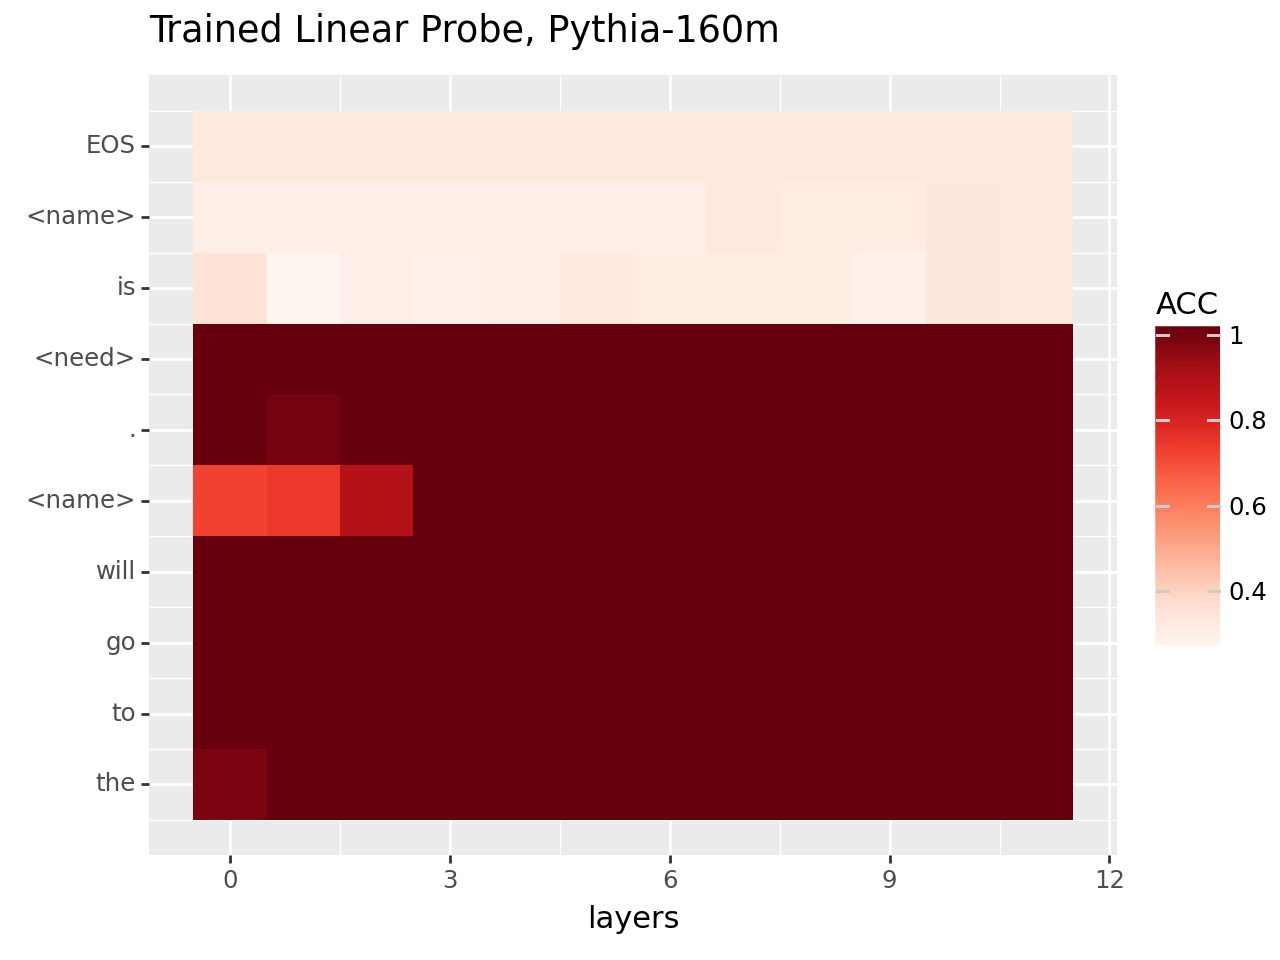

In [10]:
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    geom_line,
    geom_point,
    geom_text,
    ggtitle,
    xlab,
    ylab,
    ggsave,
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap

df = pd.read_csv(f"./pyvene_babi_nli_motivations_{model_size}.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["ACC"] = df["acc"].astype(float)

custom_labels = [
    "EOS",
    "<name>",
    "is",
    "<need>",
    ".",
    "<name>",
    "will",
    "go",
    "to",
    "the",
]
breaks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

plot = (
    ggplot(df, aes(x="layer", y="pos", fill="ACC"))
    + geom_tile()
    + scale_fill_cmap("Reds")
    + xlab("layers")
    + scale_y_reverse(breaks=breaks, labels=custom_labels)
    + ylab("")
    + theme(axis_text_y=element_text(angle=0, hjust=1))
    + ggtitle(f"Trained Linear Probe, Pythia-{model_size}")
)
ggsave(plot, filename=f"./pyvene_babi_nli_motivations_{model_size}.pdf", dpi=200)
print(plot)